In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import shutil
filename = 'glove_twitter.txt'
try:
  shutil.move(filename, "./drive/MyDrive")
except:
  print("Cant")

os.makedirs("trained_models", exist_ok=True)
os.makedirs("output", exist_ok=True)

Cant


In [4]:
import pandas as pd
import re
import numpy as np
import joblib
import nltk
import spacy
import matplotlib.pyplot as plt
nltk.download('stopwords')

def remove_digits(tweet):
  '''
    Function that takes as input a string and removes all digits
  '''
  tweet = re.sub(r'[0-9]', '', tweet)

  return tweet


def remove_links(tweet):

  '''
    Function that takes as input a string and removes all links inside of it
  '''

  tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)

  return tweet


def remove_hashtags(tweet):

    '''
      Function that takes as input a tweet and removes all hashtags
    '''
    tweet = re.sub(r'(\s)#\w+',"", tweet)

    return tweet


def remove_mentions(tweet):

  '''
    Function that takes as input a tweet and removes all mentions
  '''

  tweet = re.sub("mention+","", tweet)

  return tweet

def remove_punctuation(tweet):


    import string
    '''
      Function that takes as input a tweet and removes all punctuation
    '''

    tweet = tweet.translate(
      str.maketrans(string.punctuation + "…’”“‘", " " * (len(string.punctuation) + 5))
  )

    return tweet

def remove_extra_spaces(tweet):

  '''
    Function that takes as input a tweet and removes all extra white space
  '''

  tweet = " ".join(tweet.strip().split())

  return tweet


def remove_stopwords(tweet, language):

  '''
    Function that takes as input a tweet and removes all English stopwords
  '''
  from nltk.corpus import stopwords

  stop_words = list(set(stopwords.words(language)))
  [stop_words.append(w) for w in ["lol", "mkr", "http", "andre", "kat", "co", "rt", "oh", "lmao", "sorry","sorr", "chzjxwcj"
                                  "yggndflj", "shiizzzz", "hurrumph", "ehjqszm", "madre","moglie", "sorella", "signorine", "signora"]]  # Adding useless words that seemed to come up very often

  output =  ' '.join([word for word in tweet.split() if word not in stop_words])

  return output

def remove_emoticons(tweet):

  '''
  Function that takes as input a tweet and removes all emoji
  '''
  emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', tweet)


def cleaning(tweet, language):

  '''
    Function that takes as input a tweet and applies all preprocessing functions required to fully clean it
  '''

  tweet = tweet.lower() # standardise all tweet to lower case

  tweet = remove_digits(tweet)
  tweet = remove_extra_spaces(tweet)
  tweet = remove_punctuation(tweet)
  tweet = remove_mentions(tweet)
  tweet = remove_hashtags(tweet)
  tweet = remove_links(tweet)
  tweet = remove_emoticons(tweet)
  tweet = remove_stopwords(tweet, language)

  return tweet

!pip install deep-translator
def data_augmentation(text, translation_language):

  '''
    Function that translates text to italian and back to English for data augmentation
  '''
  from deep_translator import GoogleTranslator

  text = GoogleTranslator(source="en", target=translation_language).translate(text)
  en_text = GoogleTranslator(source=translation_language, target="en").translate(text)
  return en_text

def tf_idf_vectorise(documents_list):

  '''
      Function that TF-IDF vectorises a list of documents
  '''

  from sklearn.feature_extraction.text import TfidfVectorizer

  tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 5000, analyzer="word", stop_words='english', lowercase=False)
  tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(documents_list)
  tfidf_documents = tfidf_vectorizer_vectors.toarray()

  return tfidf_documents

# Prepare new metrics and loss

import keras
import keras.backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def pred_to_bin(preds):
  '''
    Function that turns keras probability predictions to binary
  '''

  arr = []
  i = 0
  while len(preds) > i:
    if preds[i][0] >= 0.5:
      arr.append(1)
    else:
      arr.append(0)
    i +=1

  return arr

def glove_embed(column):

  '''
    Function that glove embeds a text column of a dataframe

  input:
    column = column name

  '''

  from keras.preprocessing.text import Tokenizer

  # prepare tokenizer
  t = Tokenizer()
  t.fit_on_texts(column)
  vocab_size = len(t.word_index) + 1
  # integer encode the documents
  encoded_docs = t.texts_to_sequences(column)

  maximum_len_tweet = 15

  # Set padding
  from keras.utils import pad_sequences

  padded_docs = pad_sequences(encoded_docs, maxlen=maximum_len_tweet, padding='post')

  embeddings_dict = {}

  with open("./drive/MyDrive/glove_twitter.txt", 'r', encoding="utf-8") as f:
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector
  f.close()
  print('Loaded %s word vectors.' % len(embeddings_dict))

  # create a weight matrix for words in training docs
  from numpy import zeros

  embedding_matrix = zeros((vocab_size, 25))
  for word, i in t.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector


  return vocab_size, padded_docs, embedding_matrix

def prepare_model_output(model, X_test, y_test, model_description, is_nn):

  # Save model
  joblib.dump(model, f"./trained_models/{model_description}.pkl")

  # Predictions
  if is_nn == True:
    preds = model.predict(X_test)
    bin_preds = pred_to_bin(preds)
  else:
    bin_preds = model.predict(X_test)

  # Prepare confusion matrix
  cm = confusion_matrix(y_test, bin_preds)
  cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
  sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
  plt.savefig(f"./output/{model_description}_confusion_matrix.png")


  # # Export classification report
  report = classification_report(y_test, bin_preds, target_names=['not sexist', 'sexist'])
  with open(f"./output/{model_description}_report", "w") as text_file:
      text_file.write(report)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# FEATURE ENGINEERING

# Imports
try:
  df = pd.read_csv("./output/cleaned_english_data.csv")
except:
    raise Exception("Failure to download data")

try:
  df_augmented = pd.read_csv("./output/augmented_english_data.csv")
except:
  raise Exception("Failure to import augmented data")

df = df.dropna()
df["sexist"] = df.sexist.astype(np.int8)
df["text"] = df.text.astype("string")

df_augmented = df_augmented.dropna()
df_augmented["sexist"] = df_augmented.sexist.astype(np.int8)
df_augmented["text"] = df_augmented.text.astype("string")


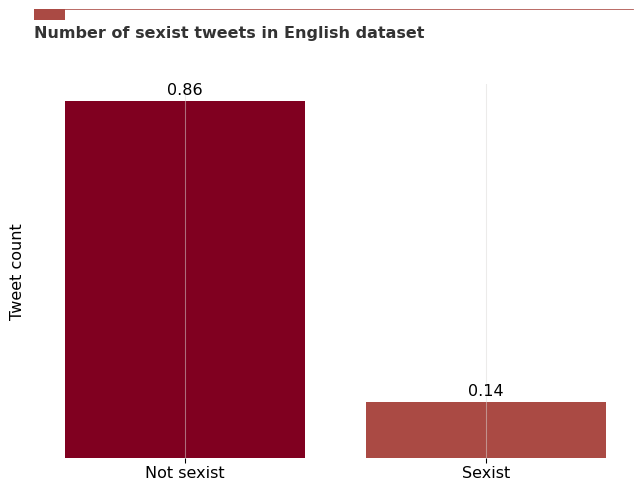

In [ ]:
# Subplots

fig, ax = plt.subplots(figsize=(8,6), dpi = 96)

# Create the grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

bar1 = ax.bar(["Not sexist", "Sexist"], df.sexist.value_counts(), color=["#800020", "#AA4A44"])
# Reformat x-axis label and tick labels
ax.set_xlabel('', fontsize=12, labelpad=10) # No need for an axis label
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)
labels = ['Not Sexist', "Sexist"]
#ax.set_xticks(df_ita.sexist, labels) # Map integers numbers from the series to labels list

# Reformat y-axis
ax.set_ylabel('Tweet count', fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)
plt.yticks([])

# Add label on top of each bar
ax.bar_label(bar1, labels=[f'{e:,.2f}' for e in df.sexist.value_counts()/len(df)], padding=3, color='black', fontsize=12)

# Remove Spines
ax.spines[['top','left','bottom', "right"]].set_visible(False)

# Add in red line and rectangle on top
ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#AA4A44', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12,.98), 0.04, -0.02, facecolor='#AA4A44', transform=fig.transFigure, clip_on=False, linewidth = 0))

# Add in title and subtitle
ax.text(x=0.12, y=.93, s="Number of sexist tweets in English dataset", transform=fig.transFigure, ha='left', fontsize=12, weight='bold', alpha=.8)

# Adjust the margins around the plot area
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

# Set a white background
fig.patch.set_facecolor('white')

plt.savefig("regular_class_unbalance.png")

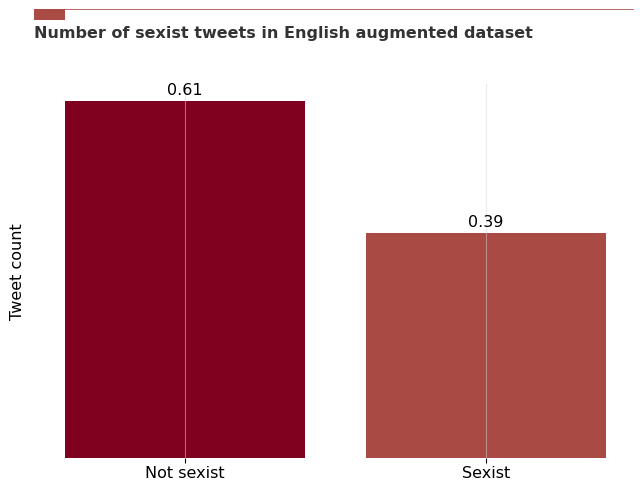

In [ ]:
# Subplots for augmented dataset

fig, ax = plt.subplots(figsize=(8,6), dpi = 96)

# Create the grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

bar1 = ax.bar(["Not sexist", "Sexist"], df_augmented.sexist.value_counts(), color=["#800020", "#AA4A44"])
# Reformat x-axis label and tick labels
ax.set_xlabel('', fontsize=12, labelpad=10) # No need for an axis label
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)
labels = ['Not Sexist', "Sexist"]
#ax.set_xticks(df_ita.sexist, labels) # Map integers numbers from the series to labels list

# Reformat y-axis
ax.set_ylabel('Tweet count', fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)
plt.yticks([])

# Add label on top of each bar
ax.bar_label(bar1, labels=[f'{e:,.2f}' for e in df_augmented.sexist.value_counts()/len(df_augmented)], padding=3, color='black', fontsize=12)

# Remove Spines
ax.spines[['top','left','bottom', "right"]].set_visible(False)

# Add in red line and rectangle on top
ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#AA4A44', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12,.98), 0.04, -0.02, facecolor='#AA4A44', transform=fig.transFigure, clip_on=False, linewidth = 0))

# Add in title and subtitle
ax.text(x=0.12, y=.93, s="Number of sexist tweets in English augmented dataset", transform=fig.transFigure, ha='left', fontsize=12, weight='bold', alpha=.8)

# Adjust the margins around the plot area
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

# Set a white background
fig.patch.set_facecolor('white')

plt.savefig("augmented_class_unbalance.png")

In [ ]:
# Train_test split
seed = 123
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sexist"], random_state=seed, test_size=0.33, stratify=df.sexist)
X_train, X_test,  y_train, y_test = pd.Series([X_train, X_test,  y_train, y_test])

augmented_X_train, augmented_X_test, augmented_y_train, augmented_y_test = train_test_split(df_augmented["text"], df_augmented["sexist"], random_state=seed, test_size=0.33, stratify=df_augmented.sexist)
augmented_X_train, augmented_X_test, augmented_y_train, augmented_y_test = pd.Series([augmented_X_train, augmented_X_test, augmented_y_train, augmented_y_test])

# TF-IDF Vectorisation
train_tweets_list = list(X_train)
train_tfidf_tweets = tf_idf_vectorise(train_tweets_list)

test_tweets_list = list(X_test)
test_tfidf_tweets = tf_idf_vectorise(test_tweets_list)

# Augmented TF-IDF Vectorisation
augmented_train_tweets_list = list(augmented_X_train)
augmented_train_tfidf_tweets = tf_idf_vectorise(augmented_train_tweets_list)

augmented_test_tweets_list = list(augmented_X_test)
augmented_test_tfidf_tweets = tf_idf_vectorise(augmented_test_tweets_list)

# Glove embeddings
train_vocab_size, train_padded_docs, train_embedding_matrix = glove_embed(X_train)
test_vocab_size, test_padded_docs, test_embedding_matrix = glove_embed(X_test)

# Augmented Glove Embed
augmented_train_vocab_size, augmented_train_padded_docs, augmented_train_embedding_matrix = glove_embed(augmented_X_train)
augmented_test_vocab_size, augmented_test_padded_docs, augmented_test_embedding_matrix = glove_embed(augmented_X_test)

Loaded 1193514 word vectors.
Loaded 1193514 word vectors.
Loaded 1193514 word vectors.
Loaded 1193514 word vectors.


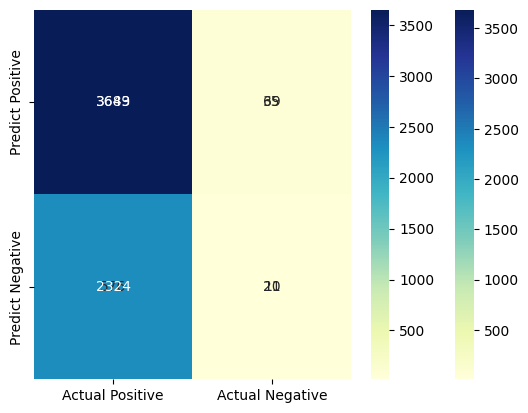

In [ ]:
## Logreg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Setup
class_imbalance = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
augmented_class_imbalance = len(augmented_y_train[augmented_y_train == 0]) / len(augmented_y_train[augmented_y_train == 1])


# Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=seed, class_weight={0:1,1:class_imbalance})
model.fit(train_tfidf_tweets, y_train)

prepare_model_output(model, test_tfidf_tweets, y_test, "regular_logreg", False)


# Augmented Logistic Regression
augmented_model = LogisticRegression(random_state=seed, class_weight={0:1,1:augmented_class_imbalance})
augmented_model.fit(augmented_train_tfidf_tweets, augmented_y_train)

prepare_model_output(augmented_model, augmented_test_tfidf_tweets, augmented_y_test, "augmented_logreg", False)

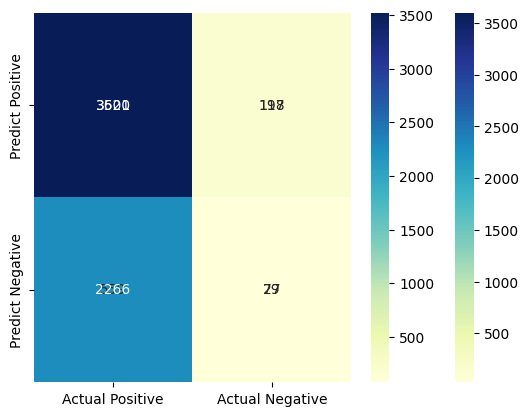

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=seed, class_weight={0:1,1:class_imbalance})
model.fit(train_tfidf_tweets, y_train)

prepare_model_output(model, test_tfidf_tweets, y_test, "regular_tree", False)


# Augmented Decision Tree
augmented_model = DecisionTreeClassifier(random_state=seed, class_weight={0:1,1:augmented_class_imbalance})
augmented_model.fit(augmented_train_tfidf_tweets, augmented_y_train)

prepare_model_output(augmented_model, augmented_test_tfidf_tweets, augmented_y_test, "augmented_tree", False)

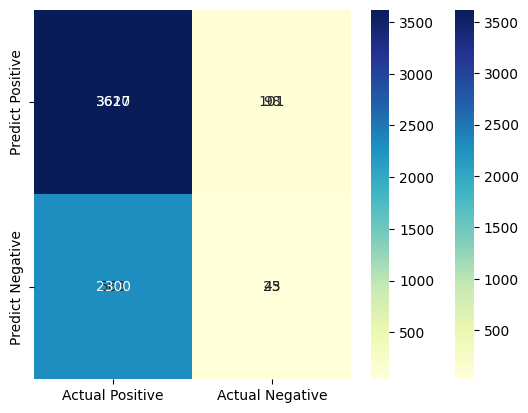

In [ ]:
# XGBOOST

from sklearn.utils import class_weight
# Prepare class weights
regular_classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y= y_train
)



# Model
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier(n_estimators=100, learning_rate=1,
                                 max_depth=1, random_state=0)


model.fit(train_tfidf_tweets, y_train, sample_weight=regular_classes_weights)


prepare_model_output(model, test_tfidf_tweets, y_test, "regular_xgboost", False)


# Augmented model

augmented_classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y= augmented_y_train
)

augmented_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1,
                                 max_depth=1, random_state=0)

augmented_model.fit(augmented_train_tfidf_tweets, augmented_y_train, sample_weight=augmented_classes_weights)

prepare_model_output(augmented_model, augmented_test_tfidf_tweets, augmented_y_test, "augmented_xgboost", False)


Epoch 1/10
219/219 [==============================] - 4s 9ms/step - loss: 0.3429 - recall_m: 0.1235 - val_loss: 0.3101 - val_recall_m: 0.5499
Epoch 2/10
219/219 [==============================] - 2s 11ms/step - loss: 0.2670 - recall_m: 0.3491 - val_loss: 0.2651 - val_recall_m: 0.3247
Epoch 3/10
219/219 [==============================] - 2s 11ms/step - loss: 0.2377 - recall_m: 0.4783 - val_loss: 0.2629 - val_recall_m: 0.5238
Epoch 4/10
219/219 [==============================] - 2s 9ms/step - loss: 0.2183 - recall_m: 0.5523 - val_loss: 0.2479 - val_recall_m: 0.4533
Epoch 5/10
219/219 [==============================] - 1s 7ms/step - loss: 0.2031 - recall_m: 0.5958 - val_loss: 0.2449 - val_recall_m: 0.3735
Epoch 6/10
219/219 [==============================] - 2s 7ms/step - loss: 0.1911 - recall_m: 0.6010 - val_loss: 0.2557 - val_recall_m: 0.5733
Epoch 7/10
219/219 [==============================] - 2s 7ms/step - loss: 0.1700 - recall_m: 0.6882 - val_loss: 0.2553 - val_recall_m: 0.6178
Epoc

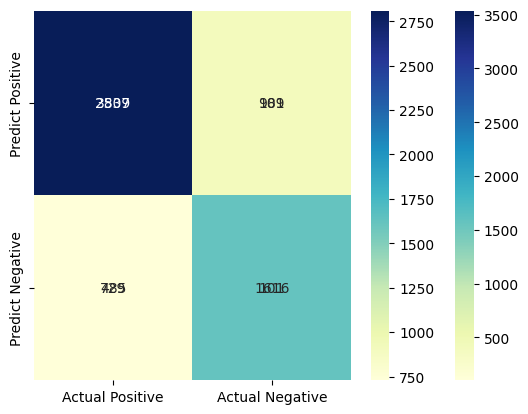

In [ ]:
# CNN
import tensorflow as tf
from keras.models import Sequential
from keras.layers import *

def CNN(vocab_size, embedding_matrix, optimisation_metric):
  model = Sequential()
  embedding = Embedding(vocab_size, 25, weights=[embedding_matrix], input_length=15, trainable=False)

  model.add(embedding)
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(MaxPooling1D(3, padding='same'))

  model.add(Dropout(0.2))

  model.add(Conv1D(128, 3, padding="same", activation='relu'))
  model.add(MaxPooling1D(3, padding='same'))


  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss="binary_crossentropy", optimizer='adam', metrics=[optimisation_metric])

  return model

model = CNN(train_vocab_size, train_embedding_matrix, recall_m)
model.fit(train_padded_docs, y_train, validation_split=0.2, epochs=10)
prepare_model_output(model, test_padded_docs, y_test, "regular_cnn", True)


augmented_model = CNN(augmented_train_vocab_size, augmented_train_embedding_matrix, recall_m)
augmented_model.fit(augmented_train_padded_docs, augmented_y_train, validation_split=0.2, epochs=10)
prepare_model_output(augmented_model, augmented_test_padded_docs, augmented_y_test, "augmented_cnn", True)

Epoch 1/10
219/219 [==============================] - 21s 54ms/step - loss: 0.3341 - recall_m: 0.1366 - val_loss: 0.2814 - val_recall_m: 0.3579
Epoch 2/10
219/219 [==============================] - 9s 40ms/step - loss: 0.2732 - recall_m: 0.2809 - val_loss: 0.2693 - val_recall_m: 0.3567
Epoch 3/10
219/219 [==============================] - 11s 52ms/step - loss: 0.2564 - recall_m: 0.3715 - val_loss: 0.2651 - val_recall_m: 0.3815
Epoch 4/10
219/219 [==============================] - 9s 39ms/step - loss: 0.2378 - recall_m: 0.4383 - val_loss: 0.2483 - val_recall_m: 0.3937
Epoch 5/10
219/219 [==============================] - 11s 50ms/step - loss: 0.2205 - recall_m: 0.5059 - val_loss: 0.2503 - val_recall_m: 0.4861
Epoch 6/10
219/219 [==============================] - 11s 51ms/step - loss: 0.2155 - recall_m: 0.5529 - val_loss: 0.2416 - val_recall_m: 0.3861
Epoch 7/10
219/219 [==============================] - 8s 38ms/step - loss: 0.1998 - recall_m: 0.5869 - val_loss: 0.2330 - val_recall_m: 0.

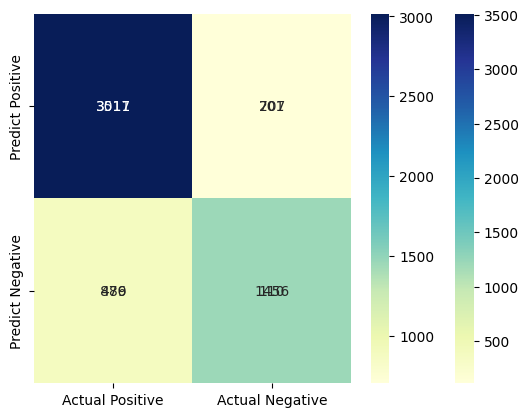

In [ ]:
## BIlstm
import tensorflow as tf
from keras.models import Sequential
from keras.layers import *

def BILSTM(vocab_size, embedding_matrix, optimisation_metric):
  model = Sequential()
  model.add(Embedding(vocab_size,
                      25,
                      weights=[embedding_matrix],
                      input_length=15,
                      trainable=False))


  model.add(Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
  model.add(Dropout(0.25))
  model.add(Bidirectional(tf.keras.layers.LSTM(32)))
  model.add(Dense(units=1, activation='sigmoid'))

  model.compile(loss="binary_crossentropy", optimizer='adam', metrics=[optimisation_metric])

  return model

model = BILSTM(train_vocab_size, train_embedding_matrix, recall_m)
model.fit(train_padded_docs, y_train, validation_split=0.2, epochs=10)
prepare_model_output(model, test_padded_docs, y_test, "regular_bilstm", True)

augmented_model = BILSTM(augmented_train_vocab_size, augmented_train_embedding_matrix, recall_m)
augmented_model.fit(augmented_train_padded_docs, augmented_y_train, validation_split=0.2, epochs=10)
prepare_model_output(augmented_model, augmented_test_padded_docs, augmented_y_test, "augmented_bilstm", True)
